In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000)

from calitp_data_analysis.tables import tbls

from siuba import *
import pandas as pd
import geopandas as gpd

import datetime as dt
from rt_analysis import signal_tools, rt_filter_map_plot

In [2]:
# from calitp_data_analysis import get_fs
# fs = get_fs()

# Signal Transit Scoring

We used three scoring components for each signal: a speed component, speed variability component, and transit frequency component. Each component is scored 0-10, and the overall transit score is a sum of all three. Higher numbers indicate more delay, more unreliability, and more frequent transit, so based on our analysis the signals with the highest combined scores would be the place to start.

Subscores are calculated seperately for all transit routes approaching a signal. To get the overall signal score, we sum the medians of all three subscores for that signal.

## Speed Score

Locates where transit speeds are relatively slow. Compares median speed of segment approaching signal to both the median speed for the entire transit system and a fixed value of 20mph.

Basic formula: ((segment_median - reference_value) / reference_value) * 10

Keep the lower of the two results from the two reference values (if transit system median speeds are above 20mph use that, otherwise use 20mph). Mask any positive scores to zero (speeds above reference), final score is the absolute value of the remaining negative scores.

### Example

* Median segment speed is 10mph and median system speed is 12mph. Since 12mph is below 20mph, use fixed 20mph for comparison formula: ((10mph - 20mph) / 20mph) * 10 = -5.0. Absolute value of -5 is 5 (final score).

## Variability Score

Ratio of 80%ile to 20%ile transit speeds * 3, with a max score of 10. Score 0 if 80%ile and 20%ile speeds the same.

### Example

* 80%ile transit speed 16mph and 20%ile speed 8mph, ratio is 2. Score is ratio * 3, 6.

## Frequency Score

Transit frequency (trips per hour) * 2, with a max score of 10.

### Examples

* 1 trip per hour = 2
* 3 trips per hour = 6
* 10 trips per hour = 10 (reached max score)

In [3]:
# path = './signals_2024-01-16.xlsx'
path = 'gs://calitp-analytics-data/data-analyses/rt_delay/signals/signals_2024-01-16.xlsx'
signal_gdf = signal_tools.read_signal_excel(path)

In [4]:
signal_gdf >> head(3)

,legacy_district_tms_id,detection_technology,funded,funded.1,user_program_type,am_tool_tms_worksheet::program_type,user_program_type.1,user_rtl,user_rtl.1,am_tool_tms_worksheet::rtl_plan_year,...,crosswalks_lpi_implemented,crosswalks_lpi_implemented_date,crosswalks_lpi_implemented_exception_comments,tms_unit_tech_projected_age,tms_id,am_tool_tms_worksheet::comments,owned_by,operated_by,maintained_by,geometry
0,01DN101-E2590,NaN,Yes,Yes,HM,HM,HM,2024.0,2024.0,2025.0,...,None,NaT,NaN,-1,0110102584PA,chronic http://sv03tmctrac/projects/tms_suppor...,Caltrans(District),Caltrans(District),Caltrans(District),POINT (-124.18538 41.75222)
1,01DN101-E2627,NaN,Yes,Yes,SHOPP,SHOPP,SHOPP,2031.0,2031.0,2031.0,...,None,NaT,NaN,-1,0110102627PS,NaN,Caltrans(District),Caltrans(District),Caltrans(District),POINT (-124.19306 41.75281)
2,01DN101-E2640,NaN,Yes,Yes,SHOPP,SHOPP,SHOPP,2031.0,2031.0,2031.0,...,None,NaT,NaN,-1,0110102642PN,NaN,Caltrans(District),Caltrans(District),Caltrans(District),POINT (-124.19447 41.75575)


# Rebuild analysis with latest speedmap data

* switch to new speed data pending
* sbmtd not available due to a feed upload gap, use last date

In [5]:
progress_df = pd.read_parquet('./_rt_progress_2023-11-15.parquet') >> filter(_.status == 'map_confirmed')

In [6]:
analysis_date = progress_df.analysis_date.iloc[0]

In [7]:
from tqdm.notebook import tqdm
pbar = tqdm()

0it [00:00, ?it/s]

In [8]:
# all_segment_gdf = signal_tools.concatenate_speedmap_segments(progress_df=progress_df, pbar=pbar)

In [9]:
progress_df >> filter(_.organization_itp_id == 293)

,organization_name,organization_itp_id,organization_source_record_id,caltrans_district,_is_current,analysis_date,status
19,Santa Barbara Metropolitan Transit District,293,recswCrw6a6htmXJ4,05 - San Luis Obispo,True,2023-11-15,map_confirmed


In [10]:
import shared_utils

In [11]:
# ## use September run for SBMTD (data gap)

# rt_day = rt_filter_map_plot.from_gcs(293, dt.date(2023, 9, 13), pbar)

# _m = rt_day.segment_speed_map(how='low_speeds', no_title=True, shn=True,
#                      no_render=True
#                     )

# dmv_proj = rt_day.detailed_map_view.to_crs(shared_utils.geography_utils.CA_NAD83Albers)
# # re-add some identifiers since we won't have the instance handy
# # dmv_proj['feed_key'] = rt_day.rt_trips.feed_key.iloc[0]
# dmv_proj['gtfs_dataset_key'] = rt_day.rt_trips.gtfs_dataset_key.iloc[0]
# dmv_proj['organization_name'] = rt_day.organization_name
# dmv_proj['system_p50_median'] = dmv_proj.p50_mph.quantile(.5)

In [12]:
# all_segment_gdf = pd.concat([all_segment_gdf, dmv_proj])

In [13]:
# all_segment_gdf.to_parquet(f'segments_all_{analysis_date}.parquet')

In [14]:
# segment_lines_all = signal_tools.copy_segment_speeds(progress_df, date_exceptions = {293: dt.date(2023, 9, 13)})

In [15]:
# segment_lines_all.to_parquet(f'./segment_lines_all_{analysis_date}.parquet')

In [16]:
segments_all = gpd.read_parquet(f'segments_all_{analysis_date}.parquet')

In [17]:
segment_lines_all = gpd.read_parquet(f'./segment_lines_all_{analysis_date}.parquet')

In [18]:
joined_seg_lines = signal_tools.sjoin_signals(signal_gdf = signal_gdf, segments_gdf = segments_all,
                                              segments_lines_gdf = segment_lines_all)

In [19]:
joined_seg_lines = signal_tools.determine_approaching(joined_seg_lines)

In [20]:
median_by_signal = signal_tools.calculate_scores(joined_seg_lines)

In [21]:
median_by_signal >> arrange(-_.overall_transit_score)

,imms_id,location,speed_score,variability_score,frequency_score,overall_transit_score
958,04SF101 -EZ465,13TH/S. VAN NESS and RTE 101 S/B ON-RAMP,7.0,7.0,10.0,24.0
959,04SF101 -EZ466,FRANKLIN/GOLDEN GATE and RTE 101 N/B OFF-RAMP,7.0,6.0,10.0,23.0
1592,06TUL063 -E4614,SR 63 (Mooney) at Tulare,6.0,10.0,7.0,23.0
931,04SF001 -EZ447,LAKE ST and PARK PRESIDIO BLVD (RTE 1),6.0,6.0,10.0,22.0
1781,07LA002 -ED198,ST ANDREWS PL,7.0,5.0,10.0,22.0
...,...,...,...,...,...,...
3082,11SD094 -E8005,DAISY DR,1.0,3.0,0.0,4.0
1001,04SM001 -E35BJ,MIRAMONTES POINT RD and CABRILLO HWY (RTE 1),0.0,3.0,0.0,3.0
1002,04SM001 -E35CC,FAIRWAY DR and CABRILLO HWY (RTE 1),0.0,3.0,0.0,3.0
3086,11SD094 -E8305,COUGAR CANYON DR /STEELE CANYON HS,0.0,3.0,0.0,3.0


## Reference Histograms for subscores

<AxesSubplot:>

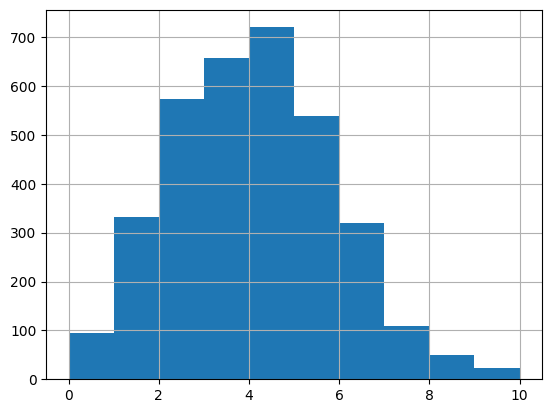

In [21]:
median_by_signal.speed_score.hist()

<AxesSubplot:>

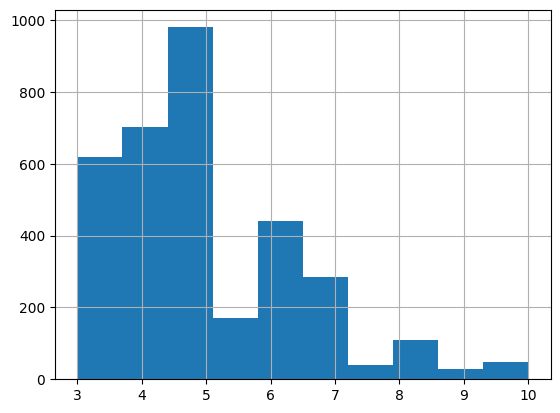

In [22]:
median_by_signal.variability_score.hist()

<AxesSubplot:>

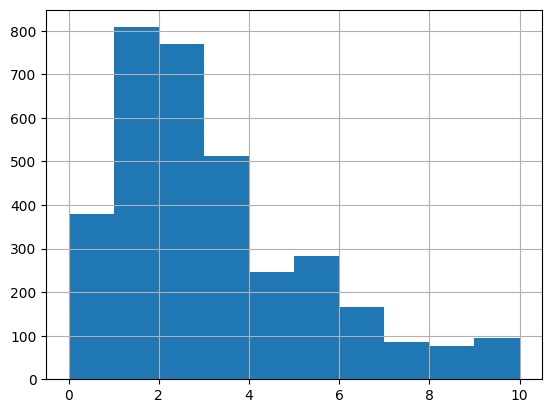

In [23]:
median_by_signal.frequency_score.hist()

<AxesSubplot:>

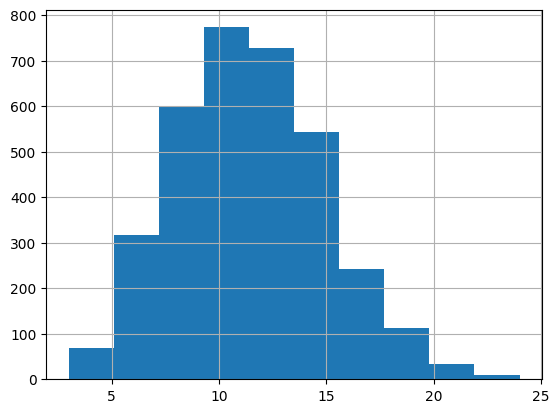

In [24]:
median_by_signal.overall_transit_score.hist()

In [25]:
median_by_signal.imms_id

958      04SF101 -EZ465
959      04SF101 -EZ466
1592    06TUL063 -E4614
931      04SF001 -EZ447
1781     07LA002 -ED198
             ...       
3082     11SD094 -E8005
1001     04SM001 -E35BJ
1002     04SM001 -E35CC
3086     11SD094 -E8305
3093     11SD094 -E8772
Name: imms_id, Length: 3421, dtype: object

In [26]:
median_by_signal['dist'] = median_by_signal.imms_id.map(lambda x: x[:2] if not pd.isna(x) else x)

In [27]:
median_by_signal >> count(_.dist)

,dist,n
0,01,48
1,02,45
2,03,172
3,04,1046
4,05,181
5,06,136
6,07,910
7,08,279
8,09,3
9,10,109


In [28]:
median_by_signal.to_excel('signals_transit_score_jan_16_2023.xlsx')

In [29]:
gdf = (signal_gdf >> select(_.imms_id, _.geometry)) >> inner_join(_, median_by_signal, on = 'imms_id')

In [30]:
# (signal_gdf >> filter(_.imms_id.str.contains('04SF101')) >> select(_.imms_id, _.location, _.geometry)).explore()

In [31]:
# gdf.explore(column = 'overall_transit_score', tiles = 'CartoDB positron', cmap='Blues')

In [32]:
import branca

In [33]:
signal_colorscale = branca.colormap.step.Purples_05.scale(vmin=0, vmax=gdf.overall_transit_score.max())

In [34]:
from shared_utils import rt_utils

In [35]:
gdf = gdf.to_crs(shared_utils.geography_utils.CA_NAD83Albers)
gdf.geometry = gdf.buffer(70)

A full state speedmap sort of works, but I suspect loading it and another layer at once hits some sort of GTFS limit...

In [36]:
sig_speeds = joined_seg_lines >> filter(_.approaching)

In [37]:
segments_all.shape

(251676, 18)

In [38]:
sig_speeds.shape

(40657, 23)

In [39]:
sig_speeds.columns

Index(['stop_id', 'stop_name', 'geometry', 'shape_id', 'stop_sequence',
       'route_id', 'route_short_name', 'direction_id', 'p50_mph', 'p20_mph',
       'p80_mph', 'fast_slow_ratio', 'trips_per_hour', 'miles_from_last',
       'time_formatted', 'gtfs_dataset_key', 'organization_name',
       'system_p50_median', 'imms_id', 'location', 'signal_pt_geom',
       'line_geom', 'approaching'],
      dtype='object')

In [40]:
sig_speeds = sig_speeds >> select(-_.signal_pt_geom, -_.imms_id, -_.location, -_.line_geom, -_.approaching,
                                 -_.time_formatted, -_.gtfs_dataset_key, -_.organization_name)

In [41]:
speedmap = rt_utils.set_state_export(sig_speeds, subfolder='signals/', filename='speeds', cmap=rt_utils.ZERO_THIRTY_COLORSCALE,
                          color_col='p20_mph', cache_seconds=1, map_type='speedmap',
                         legend_url = rt_utils.SPEEDMAP_LEGEND_URL, map_title='Speeds')

writing to calitp-map-tiles/signals/speeds.geojson.gz


In [42]:
SIGNAL_LEGEND_URL = 'https://storage.googleapis.com/calitp-map-tiles/signal_legend.svg'

In [53]:
rt_utils.set_state_export(gdf, subfolder='signals/', cmap=signal_colorscale,
                          color_col='overall_transit_score', existing_state=speedmap['state_dict'],
                         map_title='Signals with Approach Speeds', legend_url=SIGNAL_LEGEND_URL,
                         manual_centroid = [33.699342, -117.987465])

writing to calitp-map-tiles/signals/test2.geojson.gz


{'state_dict': {'name': 'null',
  'layers': [{'name': 'Speeds',
    'url': 'https://storage.googleapis.com/calitp-map-tiles/signals/speeds.geojson.gz',
    'properties': {'stroked': False,
     'highlight_saturation_multiplier': 0.5,
     'tooltip_speed_key': 'p20_mph'},
    'type': 'speedmap'},
   {'name': 'Signals with Approach Speeds',
    'url': 'https://storage.googleapis.com/calitp-map-tiles/signals/test2.geojson.gz',
    'properties': {'stroked': False, 'highlight_saturation_multiplier': 0.5}},
   {'name': 'Signals with Approach Speeds',
    'url': 'https://storage.googleapis.com/calitp-map-tiles/signals/test2.geojson.gz',
    'properties': {'stroked': False, 'highlight_saturation_multiplier': 0.5}}],
  'lat_lon': [33.699342, -117.987465],
  'zoom': 13,
  'legend_url': 'https://storage.googleapis.com/calitp-map-tiles/signal_legend.svg'},
 'spa_link': 'https://embeddable-maps.calitp.org/?state=eyJuYW1lIjogIm51bGwiLCAibGF5ZXJzIjogW3sibmFtZSI6ICJTcGVlZHMiLCAidXJsIjogImh0dHBzOi8vc3R

In [44]:
variation = rt_utils.set_state_export(sig_speeds, subfolder='signals/', filename='variation', cmap=rt_utils.VARIANCE_FIXED_COLORSCALE,
                          color_col='fast_slow_ratio', cache_seconds=1, map_type='speed_variation',
                         legend_url = 'https://storage.googleapis.com/calitp-map-tiles/variance_legend.svg', map_title='Variation')

writing to calitp-map-tiles/signals/variation.geojson.gz


In [45]:
SIGNAL_LEGEND_URL = 'https://storage.googleapis.com/calitp-map-tiles/signal_legend.svg'

In [46]:
rt_utils.set_state_export(gdf, subfolder='signals/', cmap=signal_colorscale,
                          color_col='overall_transit_score', existing_state=variation['state_dict'],
                         map_title='Signals with Approach Speed Variation', legend_url=SIGNAL_LEGEND_URL,
                         manual_centroid = [33.699342, -117.987465])

writing to calitp-map-tiles/signals/test2.geojson.gz


{'state_dict': {'name': 'null',
  'layers': [{'name': 'Variation',
    'url': 'https://storage.googleapis.com/calitp-map-tiles/signals/variation.geojson.gz',
    'properties': {'stroked': False, 'highlight_saturation_multiplier': 0.5},
    'type': 'speed_variation'},
   {'name': 'Signals with Approach Speed Variation',
    'url': 'https://storage.googleapis.com/calitp-map-tiles/signals/test2.geojson.gz',
    'properties': {'stroked': False, 'highlight_saturation_multiplier': 0.5}}],
  'lat_lon': [33.699342, -117.987465],
  'zoom': 13,
  'legend_url': 'https://storage.googleapis.com/calitp-map-tiles/signal_legend.svg'},
 'spa_link': 'https://embeddable-maps.calitp.org/?state=eyJuYW1lIjogIm51bGwiLCAibGF5ZXJzIjogW3sibmFtZSI6ICJWYXJpYXRpb24iLCAidXJsIjogImh0dHBzOi8vc3RvcmFnZS5nb29nbGVhcGlzLmNvbS9jYWxpdHAtbWFwLXRpbGVzL3NpZ25hbHMvdmFyaWF0aW9uLmdlb2pzb24uZ3oiLCAicHJvcGVydGllcyI6IHsic3Ryb2tlZCI6IGZhbHNlLCAiaGlnaGxpZ2h0X3NhdHVyYXRpb25fbXVsdGlwbGllciI6IDAuNX0sICJ0eXBlIjogInNwZWVkX3ZhcmlhdGlvbiJ9L

TODO put on a scale and ship it!

* improve export legends script!

In [47]:
[round(x, 0) for x in signal_colorscale.index[1:-1]]

[5.0, 10.0, 14.0, 19.0]

In [48]:
import export_legends

speed legend written to calitp-map-tiles/speeds_legend.svg
variance legend written to calitp-map-tiles/variance_legend.svg


In [49]:
import numpy as np

In [50]:
signal_colorscale.caption = 'Signal Transit Score'

In [52]:
# export signal_legend
signal_legend = export_legends.add_lines_header(signal_colorscale._repr_html_())
signal_legend = export_legends.add_inner_labels_caption(signal_legend,
                                        [round(x, 0) for x in signal_colorscale.index[1:-1]],
                                         100, signal_colorscale.caption)

path =  f'calitp-map-tiles/signal_legend.svg'
with fs.open(path, 'w') as writer:  # write out to public-facing GCS?
    writer.write(signal_legend)
print(f'signal legend written to {path}')

signal legend written to calitp-map-tiles/signal_legend.svg


## Provide All SHS Segments

In [45]:
from shared_utils.rt_utils import SHN_PATH
from shared_utils.geography_utils import CA_NAD83Albers
import dask_geopandas as dg

In [46]:
segment_lines_all >> head(3)

,shape_meters,stop_id,stop_name,geometry,shape_id,trip_id,stop_sequence,route_id,route_short_name,direction_id,...,meters_from_last,speed_from_last,delay_chg_sec,speed_mph,n_trips_shp,p50_mph,p20_mph,p80_mph,fast_slow_ratio,trips_per_hour
0,4000.000000,None,None,"LINESTRING (99184.376 -423695.438, 99181.943 -...",12894,143-17157330MTH,2.50,4131,73,0.0,...,1836.262692,2.333244,NaN,5.219466,1,5.219466,5.219466,5.219466,1.0,0.056518
1,4278.914082,4456052,Amgen Entrance (EB),"LINESTRING (99456.828 -424811.605, 99542.400 -...",12894,143-17157330MTH,3.00,4131,73,0.0,...,278.914082,8.716065,NaN,19.497838,1,19.497838,19.497838,19.497838,1.0,0.056518
2,6000.000000,None,None,"LINESTRING (99687.257 -424750.645, 99718.481 -...",12894,143-17157330MTH,3.25,4131,73,0.0,...,1721.085918,6.569030,NaN,14.694921,1,14.694921,14.694921,14.694921,1.0,0.056518


In [47]:
# add line geometries from stop_segment_speed_view
seg_lines = (segment_lines_all
            >> select(_.line_geom == _.geometry, _.shape_id, _.stop_sequence, _.stop_id)
            >> distinct(_.line_geom, _.shape_id, _.stop_sequence, _.stop_id)
        )
# ideally a more robust join in the future
joined_seg_lines = segments_all >> inner_join(_, seg_lines, on = ['shape_id', 'stop_sequence', 'stop_id'])

In [48]:
joined_seg_lines = joined_seg_lines.set_geometry('line_geom', drop = True)

In [49]:
joined_seg_lines >> head(3)

,stop_id,stop_name,geometry,shape_id,stop_sequence,route_id,route_short_name,direction_id,p50_mph,p20_mph,p80_mph,fast_slow_ratio,trips_per_hour,miles_from_last,time_formatted,gtfs_dataset_key,organization_name,system_p50_median
0,None,None,"LINESTRING (-90046.062 150710.584, -90046.132 ...",p_900655,2.500000,16672,7,1.0,43.6,43.6,43.6,1.0,0.1,1.1,1:30,ac2951bfaa7ecf6b80ba9e50aef1ae86,Nevada County,26.7
1,2617946,Oak Tree Rd at Tyler Foote Rd,"LINESTRING (-91197.532 149485.318, -91321.168 ...",p_900655,3.000000,16672,7,1.0,44.6,44.6,44.6,1.0,0.1,0.3,0:24,ac2951bfaa7ecf6b80ba9e50aef1ae86,Nevada County,26.7
2,None,None,"LINESTRING (-91567.382 149264.704, -91569.278 ...",p_900655,3.333333,16672,7,1.0,35.3,35.3,35.3,1.0,0.1,1.0,1:41,ac2951bfaa7ecf6b80ba9e50aef1ae86,Nevada County,26.7


In [50]:
segments_all >> head(3)

,stop_id,stop_name,geometry,shape_id,stop_sequence,route_id,route_short_name,direction_id,p50_mph,p20_mph,p80_mph,fast_slow_ratio,trips_per_hour,miles_from_last,time_formatted,gtfs_dataset_key,organization_name,system_p50_median
156,None,None,"POLYGON ((-90138.298 150418.409, -90177.775 15...",p_900655,2.500000,16672,7,1.0,43.6,43.6,43.6,1.0,0.1,1.1,1:30,ac2951bfaa7ecf6b80ba9e50aef1ae86,Nevada County,26.7
157,2617946,Oak Tree Rd at Tyler Foote Rd,"POLYGON ((-91328.902 149378.389, -91559.372 14...",p_900655,3.000000,16672,7,1.0,44.6,44.6,44.6,1.0,0.1,0.3,0:24,ac2951bfaa7ecf6b80ba9e50aef1ae86,Nevada County,26.7
158,None,None,"POLYGON ((-91593.493 149262.646, -91608.656 14...",p_900655,3.333333,16672,7,1.0,35.3,35.3,35.3,1.0,0.1,1.0,1:41,ac2951bfaa7ecf6b80ba9e50aef1ae86,Nevada County,26.7


In [51]:
shs = gpd.read_parquet(SHN_PATH).to_crs(CA_NAD83Albers)

In [52]:
shs >> head(3)

,Route,County,District,RouteType,NB,SB,EB,WB,geometry,highway_length
0,1,LA,7,State,1,1,0,0,"MULTIPOLYGON (((144885.273 -447613.479, 144886...",325266.344392
1,1,MEN,1,State,1,1,0,0,"POLYGON ((-328501.511 157787.309, -328497.074 ...",544903.330331
2,1,MON,5,State,1,1,0,0,"POLYGON ((-173401.509 -166434.139, -173403.742...",531935.433460


In [53]:
shs_dask = dg.from_geopandas(shs, npartitions=10)

In [54]:
segs_dask = dg.from_geopandas(segments_all, npartitions=10)

In [55]:
lines_dask = dg.from_geopandas(joined_seg_lines, npartitions=10)

In [56]:
shs_segs_joined = segs_dask.sjoin(shs_dask)

In [57]:
shs_segs_joined_computed = shs_segs_joined.compute()


KeyboardInterrupt



In [ ]:
shs_segs_joined_computed >> head(3)

In [ ]:
shs_lines_joined = lines_dask.sjoin(shs_dask)

In [ ]:
shs_lines_joined_computed = shs_lines_joined.compute()

In [ ]:
shs_lines_joined_computed >> head(3)

In [ ]:
shs_lines_joined_computed.columns

In [ ]:
shs_lines_joined_computed = shs_lines_joined_computed >> select(-_.time_from_last, -_.index_right, -_.highway_length,
                                                            -_.EB, -_.WB, -_.NB, -_.SB)

In [ ]:
shs_lines_joined_computed.to_file('transit_lines_shs_joined.geojson')

In [ ]:
shs_segs_joined_computed.to_file('transit_polygons_shs_joined.geojson')